<a href="https://colab.research.google.com/github/ritwiks9635/My_Neural_Network_Architecture/blob/main/RandAugment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **RandAugment for Image Classification for Improved Robustness**

Data augmentation is a very useful technique that can help to improve the translational
invariance of convolutional neural networks (CNN). RandAugment is a stochastic data
augmentation routine for vision data and was proposed in
[RandAugment: Practical automated data augmentation with a reduced search space](https://arxiv.org/abs/1909.13719).
It is composed of strong augmentation transforms like color jitters, Gaussian blurs,
saturations, etc. along with more traditional augmentation transforms such as
random crops.

RandAugment has two parameters:

* `n` that denotes the number of randomly selected augmentation transforms to apply
sequentially
* `m` strength of all the augmentation transforms

These parameters are tuned for a given dataset and a network architecture. The authors of
RandAugment also provide pseudocode of RandAugment in the original paper (Figure 2).

Recently, it has been a key component of works like
[Noisy Student Training](https://arxiv.org/abs/1911.04252) and
[Unsupervised Data Augmentation for Consistency Training](https://arxiv.org/abs/1904.12848).
It has been also central to the
success of [EfficientNets](https://arxiv.org/abs/1905.11946).

This example requires TensorFlow 2.4 or higher, as well as
[`imgaug`](https://imgaug.readthedocs.io/),
which can be installed using the following command:

In [8]:
pip install imgaug

In [9]:
import numpy as np
import imgaug as ia
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from imgaug import augmenters as iaa
from tensorflow.keras import layers

ia.seed(42)
tf.random.set_seed(42)

In [10]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
print(f"Total training examples: {len(x_train)}")
print(f"Total test examples: {len(x_test)}")

170498071/170498071 [==============================] - 111s 1us/step
Total training examples: 50000
Total test examples: 10000


In [11]:
AUTO = tf.data.AUTOTUNE
BATCH_SIZE = 128
EPOCHS = 1
IMAGE_SIZE = 72

## Initialize `RandAugment` object

Now, we will initialize a `RandAugment` object from the `imgaug.augmenters` module with
the parameters suggested by the RandAugment authors.

In [12]:
rand_aug = iaa.RandAugment(n=3, m=7)


def augment(images):
    # Input to `augment()` is a TensorFlow tensor which
    # is not supported by `imgaug`. This is why we first
    # convert it to its `numpy` variant.
    images = tf.cast(images, tf.uint8)
    return rand_aug(images=images.numpy())

## Create TensorFlow `Dataset` objects

Because `RandAugment` can only process NumPy arrays, it
cannot be applied directly as part of the `Dataset` object (which expects TensorFlow
tensors). To make `RandAugment` part of the dataset, we need to wrap it in a
[`tf.py_function`](https://www.tensorflow.org/api_docs/python/tf/py_function).

A `tf.py_function` is a TensorFlow operation (which, like any other TensorFlow operation,
takes TF tensors as arguments and returns TensorFlow tensors) that is capable of running
arbitrary Python code. Naturally, this Python code can only be executed on CPU (whereas
the rest of the TensorFlow graph can be accelerated on GPU), which in some  cases can
cause significant slowdowns -- however, in this case, the `Dataset` pipeline will run
asynchronously together with the model, and doing preprocessing on CPU will remain
performant.

In [13]:
train_ds_rand = (
    tf.data.Dataset.from_tensor_slices((x_train, y_train))
    .shuffle(BATCH_SIZE * 100)
    .batch(BATCH_SIZE)
    .map(
        lambda x, y: (tf.image.resize(x, (IMAGE_SIZE, IMAGE_SIZE)), y),
        num_parallel_calls=AUTO)
    .map(
        lambda x, y: (tf.py_function(augment, [x], [tf.float32])[0], y),
        num_parallel_calls=AUTO)
    .prefetch(AUTO))

test_ds = (
    tf.data.Dataset.from_tensor_slices((x_test, y_test))
    .batch(BATCH_SIZE)
    .map(
        lambda x, y: (tf.image.resize(x, (IMAGE_SIZE, IMAGE_SIZE)), y),
        num_parallel_calls=AUTO)
    .prefetch(AUTO))

**Note about using `tf.py_function`**:

* As our `augment()` function is not a native TensorFlow operation chances are likely
that it can turn into an expensive operation. This is why it is much better to apply it
_after_ batching our dataset.
* `tf.py_function` is [not compatible](https://github.com/tensorflow/tensorflow/issues/38762)
with TPUs. So, if you have distributed TensorFlow training pipelines that use TPUs
you cannot use `tf.py_function`. In that case, consider switching to a multi-GPU environment,
or rewriting the contents of the function in pure TensorFlow.

For comparison purposes, let's also define a simple augmentation pipeline consisting of
random flips, random rotations, and random zoomings.

In [14]:
simple_aug = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(factor = 0.02),
    layers.RandomZoom(height_factor = 0.2, width_factor = 0.2)
    ])

train_ds_simple = (tf.data.Dataset.from_tensor_slices((x_train, y_train))
                  .shuffle(BATCH_SIZE * 100)
                  .batch(BATCH_SIZE)
                  .map(lambda x, y : (simple_aug(x), y), num_parallel_calls = AUTO)
                  .prefetch(AUTO))

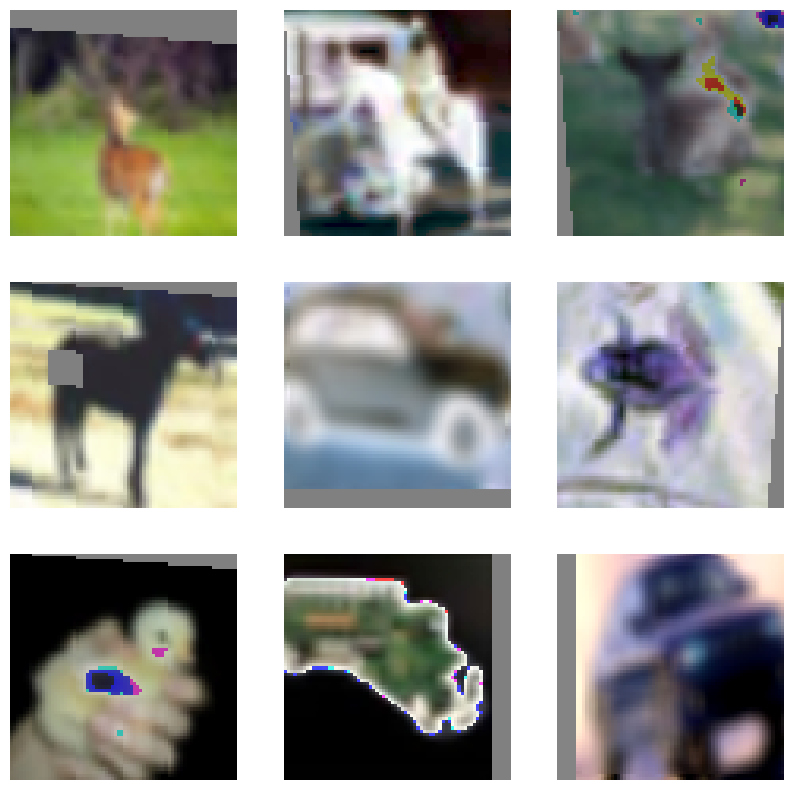

In [15]:
sample_images, _ = next(iter(train_ds_rand))
plt.figure(figsize=(10, 10))
for i, image in enumerate(sample_images[:9]):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("int"))
    plt.axis("off")

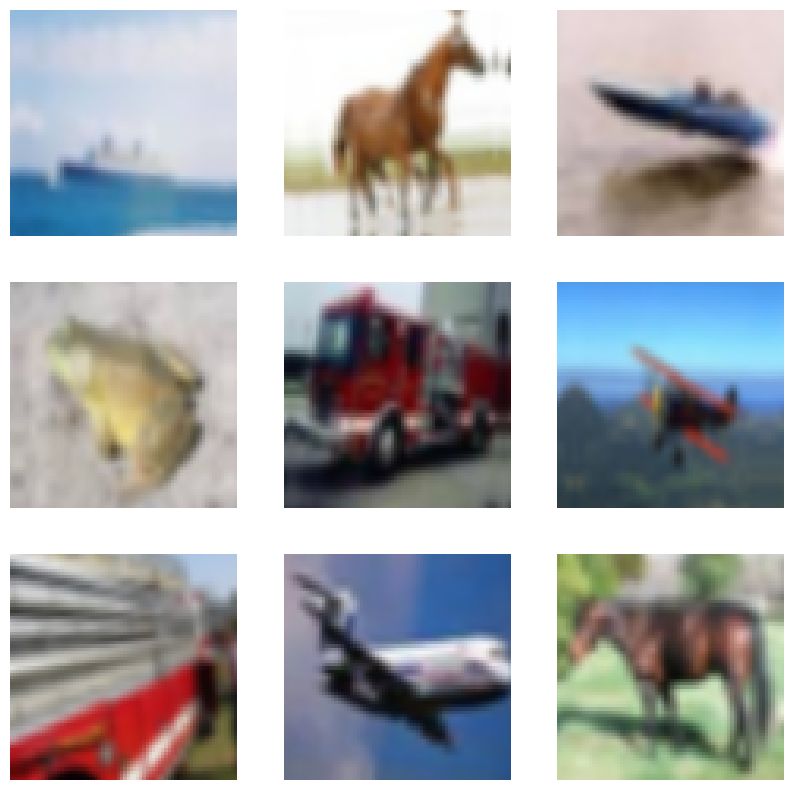

In [16]:
sample_images, _ = next(iter(train_ds_simple))
plt.figure(figsize=(10, 10))
for i, image in enumerate(sample_images[:9]):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("int"))
    plt.axis("off")

In [17]:
def get_training_model():
    resnet50_v2 = tf.keras.applications.ResNet50V2(
        weights=None,
        include_top=True,
        input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
        classes=10,
    )
    model = tf.keras.Sequential(
        [
            layers.Input((IMAGE_SIZE, IMAGE_SIZE, 3)),
            layers.Rescaling(scale=1.0 / 127.5, offset=-1),
            resnet50_v2,
        ]
    )
    return model

print(get_training_model().summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 72, 72, 3)         0         
                                                                 
 resnet50v2 (Functional)     (None, 10)                23585290  
                                                                 
Total params: 23585290 (89.97 MB)
Trainable params: 23539850 (89.80 MB)
Non-trainable params: 45440 (177.50 KB)
_________________________________________________________________
None


We will train this network on two different versions of our dataset:

* One augmented with RandAugment.
* Another one augmented with `simple_aug`.

Since RandAugment is known to enhance the robustness of models to common perturbations
and corruptions, we will also evaluate our models on the CIFAR-10-C dataset, proposed in
[Benchmarking Neural Network Robustness to Common Corruptions and Perturbations](https://arxiv.org/abs/1903.12261)
by Hendrycks et al. The CIFAR-10-C dataset
consists of 19 different image corruptions and perturbations (for example speckle noise,
fog, Gaussian blur, etc.) that too at varying severity levels. For this example we will
be using the following configuration:
[`cifar10_corrupted/saturate_5`](https://www.tensorflow.org/datasets/catalog/cifar10_corrupted#cifar10_corruptedsaturate_5).
The images from this configuration look like so:

![](https://storage.googleapis.com/tfds-data/visualization/fig/cifar10_corrupted-saturate_5-1.0.0.png)

In the interest of reproducibility, we serialize the initial random weights of our shallow
network.

In [18]:
initial_model = get_training_model()
initial_model.save_weights("initial_weights.h5")

## Train model with RandAugment

In [19]:
rand_aug_model = get_training_model()
rand_aug_model.load_weights("initial_weights.h5")
rand_aug_model.compile(
    loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
rand_aug_model.fit(train_ds_rand, validation_data=test_ds, epochs=EPOCHS)
_, test_acc = rand_aug_model.evaluate(test_ds)
print("Test accuracy: {:.2f}%".format(test_acc * 100))

79/79 [==============================] - 5s 59ms/step - loss: 1.4349 - accuracy: 0.4975
Test accuracy: 49.75%


## Train model with `simple_aug`

In [20]:
simple_aug_model = get_training_model()
simple_aug_model.load_weights("initial_weights.h5")
simple_aug_model.compile(
    loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
simple_aug_model.fit(train_ds_simple, validation_data=test_ds, epochs=EPOCHS)
_, test_acc = simple_aug_model.evaluate(test_ds)
print("Test accuracy: {:.2f}%".format(test_acc * 100))

79/79 [==============================] - 4s 56ms/step - loss: 1.5196 - accuracy: 0.5110
Test accuracy: 51.10%


In [21]:
# Load and prepare the CIFAR-10-C dataset
# (If it's not already downloaded, it takes ~10 minutes of time to download)
cifar_10_c = tfds.load("cifar10_corrupted/saturate_5", split="test", as_supervised=True)
cifar_10_c = cifar_10_c.batch(BATCH_SIZE).map(
    lambda x, y: (tf.image.resize(x, (IMAGE_SIZE, IMAGE_SIZE)), y),
    num_parallel_calls=AUTO,
)

# Evaluate `rand_aug_model`
_, test_acc = rand_aug_model.evaluate(cifar_10_c, verbose=0)
print(
    "Accuracy with RandAugment on CIFAR-10-C (saturate_5): {:.2f}%".format(
        test_acc * 100
    )
)

# Evaluate `simple_aug_model`
_, test_acc = simple_aug_model.evaluate(cifar_10_c, verbose=0)
print(
    "Accuracy with simple_aug on CIFAR-10-C (saturate_5): {:.2f}%".format(
        test_acc * 100
    )
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10_corrupted/saturate_5/1.0.0.incompleteYWO2DX/cifar10_corrupted-test…

Dataset cifar10_corrupted downloaded and prepared to /root/tensorflow_datasets/cifar10_corrupted/saturate_5/1.0.0. Subsequent calls will reuse this data.
Accuracy with RandAugment on CIFAR-10-C (saturate_5): 30.48%
Accuracy with simple_aug on CIFAR-10-C (saturate_5): 40.17%


For the purpose of this example, we trained the models for only a single epoch. On the
CIFAR-10-C dataset, the model with RandAugment can perform better with a higher accuracy
(for example, 76.64% in one experiment) compared with the model trained with `simple_aug`
(e.g., 64.80%). RandAugment can also help stabilize the training. You can explore this
[notebook](https://nbviewer.jupyter.org/github/sayakpaul/Keras-Examples-RandAugment/blob/main/RandAugment.ipynb) to check some of the results.

In the notebook, you may notice that, at the expense of increased training time with RandAugment,
we are able to carve out far better performance on the CIFAR-10-C dataset. You can
experiment on the other corruption and perturbation settings that come with the
run the same CIFAR-10-C dataset and see if RandAugment helps.

You can also experiment with the different values of `n` and `m` in the `RandAugment`
object. In the [original paper](https://arxiv.org/abs/1909.13719), the authors show
the impact of the individual augmentation transforms for a particular task and a range of
ablation studies. You are welcome to check them out.

RandAugment has shown great progress in improving the robustness of deep models for
computer vision as shown in works like [Noisy Student Training](https://arxiv.org/abs/1911.04252) and
[FixMatch](https://arxiv.org/abs/2001.07685). This makes RandAugment quite a useful
recipe for training different vision models.

You can use the trained model hosted on [Hugging Face Hub](https://huggingface.co/keras-io/randaugment)
and try the demo on [Hugging Face Spaces](https://huggingface.co/spaces/keras-io/randaugment).